In [1]:
import pandas as pd
from metar import Metar
import numpy as np
from IOfuncs import *
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFdr,SelectFpr,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')

In [2]:
def make_ml_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2):
    if isinstance(metar_path, str):
        metar_path = read_metar(metar_path)
    metarDF = pd.DataFrame()
    glampDF = pd.DataFrame()
    hrrrDF = pd.DataFrame()    
    
    #right now hardcoded to look at metars for 2 hours before TAF due and then predictions after
    for time in range(-6, -delay_hours, 1):
        metar_at_time = get_metar_at_time(taf_time + dt.timedelta(hours = time), metar_path).T
        metarDF[f'metar {time}'] = metar_at_time
    
    work_time = dt.timedelta(hours=-delay_hours)
    glamp_data = get_glamp_at_time(taf_time + work_time, glamp_path, station, download=True)
    hrrr_data = get_hrrr_at_time(taf_time + work_time, hrrr_path, lat, lon, download=True)
    glamp_synoptic_offset = (taf_time.hour - delay_hours) % 6 - 1
    for time in range(-delay_hours, 7, 1):
        glampDF[f'glamp {time}'] = glamp_data.iloc[time + delay_hours + glamp_synoptic_offset]
        hrrrDF[f'hrrr {time}'] = hrrr_data.iloc[time + delay_hours]    
        
    
    df = pd.concat([metarDF, glampDF, hrrrDF])
    df.drop(['ftime', 'ftime_utc', 'model', 'runtime', 'runtime_utc', 'station', 'metar', 'peak_wind_time', 'valid', 'Unnamed: 0'], inplace=True)

    v = df.unstack().to_frame().sort_index(level=1).T
    v.columns = v.columns.map('_'.join)

    final = v.dropna(axis = 1)
    
    return final

In [3]:
taf_time = dt.datetime(year = 2021, month = 8, day = 21, hour = 18, minute = 16)

In [4]:
make_ml_data_row(taf_time, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/')

,hrrr -1_DPT_1000mb,hrrr -2_DPT_1000mb,hrrr 0_DPT_1000mb,hrrr 1_DPT_1000mb,hrrr 2_DPT_1000mb,hrrr 3_DPT_1000mb,hrrr 4_DPT_1000mb,hrrr 5_DPT_1000mb,hrrr 6_DPT_1000mb,hrrr -1_DPT_2m_above_ground,...,glamp 6_wdr,glamp -1_wsp,glamp -2_wsp,glamp 0_wsp,glamp 1_wsp,glamp 2_wsp,glamp 3_wsp,glamp 4_wsp,glamp 5_wsp,glamp 6_wsp
0,292.8,293.5,292.2,292.0,291.8,294.0,293.5,292.2,293.2,293.2,...,90.0,8.0,7.0,9.0,9.0,9.0,9.0,8.0,8.0,7.0


In [5]:
def make_ml_training_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2, tplus_hours = 6):
    if isinstance(metar_path, str):
        metar_path = full_metar_list = read_metar(metar_path)
    
    df = make_ml_data_row(taf_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = delay_hours)
    
    for i in range(tplus_hours):
        metar_at_time = get_metar_at_time(taf_time + dt.timedelta(hours = i), metar_path)
        vis = metar_at_time['vsby']
        ceiling = find_ceiling_height(metar_at_time['metar'])
        if ceiling is None:
            ceiling = 100000

        if ceiling < 500 or vis < 1:
            conditions = 0
        elif ceiling < 1000 or vis < 3:
            conditions = 1
        elif ceiling < 3000 or vis < 5:
            conditions = 2
        else:
            conditions = 3

        df[f'flight category {i}'] = conditions

    return df

In [6]:
make_ml_training_data_row(taf_time, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/')['flight category 3']

0    3
Name: flight category 3, dtype: int64

In [7]:
def make_ml_training_data_set(start_time, end_time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = 2, frequency = '5H'):
    training_df = pd.DataFrame()
    time_series = pd.date_range(start_time, end_time, freq = frequency)
    if isinstance(metar_path, str):
        metar_path = read_metar(metar_path)
    for time in tqdm(time_series):
        try:
            training_row = make_ml_training_data_row(time, station, lat, lon, metar_path, glamp_path, hrrr_path, delay_hours = delay_hours)
            training_df = pd.concat([training_df, training_row])
        except FileNotFoundError:
            print(time)
            continue

    training_df = training_df.fillna(-99999)
    return training_df

In [8]:
def prob_of_detection(predicted_results, actual_results, flight_cat):
    result_locations = np.where(actual_results==flight_cat)[0]
    num_predict = np.sum(predicted_results[result_locations]==flight_cat)
    return num_predict / len(result_locations)

def false_alarm_rate(predicted_results, actual_results, flight_cat):
    num_predict = np.sum(predicted_results==flight_cat)
    predict_locations = np.where(predicted_results==flight_cat)[0]
    predict_subset = predicted_results[predict_locations]
    actual_subset = actual_results.iloc[predict_locations]
    
    false_alarm_count = np.sum(predict_subset!=actual_subset)
    
    return false_alarm_count/num_predict

def critical_success_index(predicted_results, actual_results, flight_cat):
    num_predict = np.sum(predicted_results==flight_cat)
    predict_locations = np.where(predicted_results==flight_cat)[0]
    non_predict_locations = np.where(predicted_results!=flight_cat)[0]
    predict_subset = predicted_results[predict_locations]
    actual_subset = actual_results.iloc[predict_locations]
    actual_subset_compliment = actual_results.iloc[non_predict_locations]
    
    hits = np.sum(predict_subset==actual_subset)
    false_alarm_count = np.sum(predict_subset!=actual_subset)
    misses = np.sum(actual_subset_compliment==flight_cat)
    
    return hits / (hits + false_alarm_count + misses)

In [9]:
def prob_of_detection_nfv(predicted_results, actual_results):
    result_locations = np.where(actual_results!=3)[0]
    num_predict = np.sum(predicted_results[result_locations]!=3)
    return num_predict / len(result_locations)

def false_alarm_rate_nfv(predicted_results, actual_results):
    num_predict = np.sum(predicted_results!=3)
    predict_locations = np.where(predicted_results!=3)[0]
    predict_subset = predicted_results[predict_locations]
    actual_subset = actual_results.iloc[predict_locations]
    
    false_alarm_count = np.sum(predict_subset!=actual_subset)
    
    return false_alarm_count/num_predict

def critical_success_index_nfv(predicted_results, actual_results):
    num_predict = np.sum(predicted_results!=3)
    predict_locations = np.where(predicted_results!=3)[0]
    non_predict_locations = np.where(predicted_results==3)[0]
    predict_subset = predicted_results[predict_locations]
    actual_subset = actual_results.iloc[predict_locations]
    actual_subset_compliment = actual_results.iloc[non_predict_locations]
    
    hits = np.sum(predict_subset==actual_subset)
    false_alarm_count = np.sum(predict_subset!=actual_subset)
    misses = np.sum(actual_subset_compliment!=3)
    
    return hits / (hits + false_alarm_count + misses)

In [10]:
def data_split(data):
    y_keys = np.asarray([key for key in data if 'flight category' in key])
    X = data.drop(y_keys, axis=1)
    y_list = data[y_keys]
    return X, y_list


In [27]:
start_date = dt.datetime(year = 2021, month = 1, day = 1, hour = 0, minute = 0)
end_date = dt.datetime(year = 2021, month = 12, day = 31, hour = 23, minute = 0)
data = make_ml_training_data_set(start_date, end_date, 'kbos', 42.3656, -71.0096, 'Data/BOS.csv', 'Data/GLAMP data/', 'Data/hrrr/', frequency = 'H')

 15%|████████████▏                                                                  | 1351/8760 [02:44<46:36,  2.65it/s]

2021-02-26 05:00:00


 24%|███████████████████▏                                                           | 2121/8760 [04:34<21:30,  5.14it/s]

2021-03-30 08:00:00


 24%|███████████████████▏                                                           | 2122/8760 [04:35<22:40,  4.88it/s]

2021-03-30 09:00:00


 24%|███████████████████▏                                                           | 2123/8760 [04:35<24:08,  4.58it/s]

2021-03-30 10:00:00


 24%|███████████████████▏                                                           | 2124/8760 [04:35<25:09,  4.40it/s]

2021-03-30 11:00:00


 24%|███████████████████▏                                                           | 2125/8760 [04:35<27:51,  3.97it/s]

2021-03-30 12:00:00


 24%|███████████████████▏                                                           | 2127/8760 [04:36<24:45,  4.46it/s]

2021-03-30 13:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6867/8760 [23:39<08:31,  3.70it/s]

2021-10-14 02:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6868/8760 [23:39<08:50,  3.57it/s]

2021-10-14 03:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6869/8760 [23:39<08:33,  3.68it/s]

2021-10-14 04:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6870/8760 [23:40<08:32,  3.69it/s]

2021-10-14 05:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6871/8760 [23:40<08:52,  3.54it/s]

2021-10-14 06:00:00


 78%|█████████████████████████████████████████████████████████████▉                 | 6872/8760 [23:40<08:49,  3.57it/s]

2021-10-14 07:00:00


100%|███████████████████████████████████████████████████████████████████████████████| 8760/8760 [33:26<00:00,  4.36it/s]


In [28]:
data.to_csv('2021trainingdata.csv')

In [29]:
def test_accuracy_metrics(classifier_rf, training_data, flight_cat):
    result_df = pd.DataFrame()
    (X, y_list) = data_split(training_data)
    for y in y_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y_list[y], train_size=0.7, random_state=42)
        classifier_rf.fit(X_train, y_train)
        prob = classifier_rf.predict(X_test)
        result_df[y] = (prob_of_detection(prob, y_test, flight_cat), 
                        false_alarm_rate(prob, y_test, flight_cat), 
                        critical_success_index(prob, y_test, flight_cat))
        result_df.rename({0: 'POD', 1: 'FAR', 2: 'CSI'}, inplace=True)
    return result_df

In [48]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs = -1)
#params determined via hyperparam tuning
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_depth = [x for x in range(10, 120, 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
tuned_rf = RandomizedSearchCV(estimator = classifier_rf, param_distributions = random_grid, random_state = 42, n_jobs = -1)

In [ ]:
def test_accuracy_metrics_nfv(classifier_rf, training_data):
    result_df = pd.DataFrame()
    (X, y_list) = data_split(training_data)
    for y in y_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y_list[y], train_size=0.7, random_state=42)
        classifier_rf.fit(X_train, y_train)
        prob = classifier_rf.predict(X_test)
        result_df[y] = (prob_of_detection_nfv(prob, y_test), 
                        false_alarm_rate_nfv(prob, y_test), 
                        critical_success_index_nfv(prob, y_test))
        result_df.rename({0: 'POD', 1: 'FAR', 2: 'CSI'}, inplace=True)
    return result_df

In [ ]:
%%time
test_accuracy_metrics(tuned_rf, data, 3) #VFR

In [ ]:
%%time
test_accuracy_metrics(tuned_rf, data, 2) #MVFR

In [ ]:
%%time
test_accuracy_metrics(tuned_rf, data, 1) #IFR

In [ ]:
%%time
test_accuracy_metrics(tuned_rf, data, 0) #LIFR

In [36]:
%%time
test_accuracy_metrics_nfv(classifier_rf, data) #Non-VFR

CPU times: user 26min 15s, sys: 8.11 s, total: 26min 23s
Wall time: 1min 48s


,flight category 0,flight category 1,flight category 2,flight category 3,flight category 4,flight category 5
POD,0.776699,0.777132,0.822485,0.814371,0.775000,0.773256
FAR,0.295711,0.324324,0.327511,0.300216,0.281106,0.302961
CSI,0.559140,0.536673,0.562044,0.582734,0.566243,0.550360


In [20]:
%%time
(X, y_list) = data_split(data)
X_train, X_test, y_train, y_test = train_test_split(X, y_list['flight category 0'], train_size=0.7, random_state=42)
classifier_rf.fit(X_train, y_train)

imports = classifier_rf.feature_importances_

CPU times: user 38.4 s, sys: 5.43 s, total: 43.9 s
Wall time: 6.4 s


In [21]:
importances = [(feature, sig) for feature, sig in zip(classifier_rf.feature_names_in_, imports)]
importances.sort(key = lambda x: x[1])
importances

[('glamp -1_lc1', 0.0),
 ('glamp 0_lc1', 0.0),
 ('glamp 1_lc1', 0.0),
 ('glamp 2_lc1', 0.0),
 ('glamp 3_lc1', 0.0),
 ('glamp 4_lc1', 0.0),
 ('glamp 5_lc1', 0.0),
 ('glamp 6_lc1', 0.0),
 ('metar -3_skyc4', 0.0),
 ('metar -4_skyc4', 7.927199268278118e-07),
 ('metar -4_skyl4', 1.1480130194348565e-06),
 ('metar -3_skyl4', 1.219489586888618e-06),
 ('metar -6_skyc4', 4.6219474178828244e-06),
 ('metar -6_skyl4', 6.40172010616078e-06),
 ('metar -5_skyc4', 1.058446069997152e-05),
 ('metar -5_skyl4', 1.3568929866757425e-05),
 ('glamp 5_lp1', 1.495471276655928e-05),
 ('glamp 6_lp1', 2.5505491893115386e-05),
 ('glamp 3_lp1', 5.527018388697876e-05),
 ('glamp 1_lp1', 5.765901822499133e-05),
 ('glamp 6_cc1', 6.112520516150287e-05),
 ('metar -4_peak_wind_gust', 6.575209408205844e-05),
 ('glamp 4_pc1', 6.68416276289507e-05),
 ('glamp 6_pc1', 6.69167311716061e-05),
 ('glamp 6_cld', 6.867490968884719e-05),
 ('glamp -2_lc1', 6.908823320707546e-05),
 ('glamp -2_lp1', 7.281972320242279e-05),
 ('glamp 4_lp1'

In [22]:
%%time
result = permutation_importance(
    classifier_rf, X_test, y_test, random_state=42, n_jobs=-1
)
#takes about 10 min

CPU times: user 5min 56s, sys: 13.1 s, total: 6min 9s
Wall time: 6min 55s


In [23]:
importances = [(feature, sig) for feature, sig in zip(classifier_rf.feature_names_in_, result['importances_mean'])]
#importances.sort(key = lambda x: x[0].split('_')[1])
importances.sort(key = lambda x: -x[1])
importances = pd.DataFrame(importances)

In [24]:
np.max(importances[1]), np.min(importances[1]), np.mean(importances[1]), np.std(importances[1])

(0.0017391304347826875,
 -0.005913043478260849,
 -5.038318537066073e-05,
 0.000520873868325348)

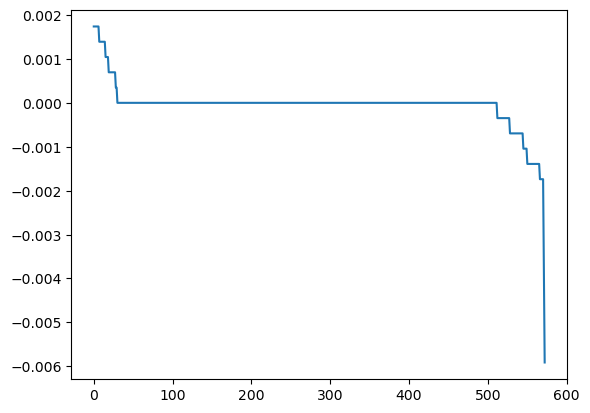

In [25]:
plt.plot(importances[1])

In [26]:
with pd.option_context('display.max_rows', 999):
    print(importances)

                                 0             1
0         hrrr 5_HGT_cloud_ceiling  1.739130e-03
1               hrrr -1_UGRD_250mb  1.739130e-03
2               hrrr -2_VGRD_250mb  1.739130e-03
3               hrrr -2_VGRD_300mb  1.739130e-03
4                      glamp 5_ccg  1.739130e-03
5                      glamp 5_cig  1.739130e-03
6                      glamp 1_cig  1.739130e-03
7                hrrr 1_UGRD_700mb  1.391304e-03
8                hrrr 2_UGRD_700mb  1.391304e-03
9                hrrr 6_VGRD_500mb  1.391304e-03
10                     glamp 3_cc1  1.391304e-03
11                     glamp 0_ccg  1.391304e-03
12                     glamp 4_ccg  1.391304e-03
13                     glamp 2_cp1  1.391304e-03
14                     glamp 3_p01  1.391304e-03
15                     glamp 1_ppo  1.043478e-03
16                     glamp 2_ppo  1.043478e-03
17                     glamp 3_ppo  1.043478e-03
18                   metar -4_relh  1.043478e-03
19    hrrr 2_UGRD_10